In [1]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K


import gc
import argparse


In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.set_visible_devices(gpus[0], 'GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-06-24 21:23:29.387058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-24 21:23:29.405262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-24 21:23:29.405521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# standard numerical library imports
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import sys

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical


In [4]:
sys.path.append('../20240503')
import DCTR


In [5]:
def get_rwgt(model_list, x1_plt, x1_nrm, batch_size = 5*8192):
    with tf.device('/cpu:0'): # otherwise smoetimes tries to do this on the GPU, for which there is not enough memory
        x1_nrm = tf.convert_to_tensor(x1_nrm)
    
    rwgt_list = np.empty(shape = (len(model_list),len(x1_plt)), dtype = np.float64)
    for i, model in enumerate(model_list):
        K.clear_session()
        dctr = tf.keras.models.load_model(model)
        with tf.device('/gpu:0'):
            preds = dctr.predict(x1_nrm, batch_size=batch_size)
        rwgt = np.divide(preds[:,0], preds[:,1])
        # set wgts of events with pt > 1000 to 1
        for k, _ in enumerate(rwgt):
            if (x1_plt[k,0]>1000):
                rwgt[k] = 1
        
        rwgt_list[i] = rwgt
        print(f'finished calculating weights for {i+1} models')
    K.clear_session()
    return rwgt_list


In [6]:
sample_dir = '/tf/data/BachelorThesis_Data/Valentinas_Samples/test_samples_ready' # local docker 
# sample_dir = '/nfs/dust/cms/user/vaguglie/converterLHEfiles/Hdamp13TeV' # NAF


In [7]:
data_dir = '../../Data/hdamp_down'


In [8]:
dataset=np.load(f'{sample_dir}/X_Nom_TestAll_13TeV_test_plot.npz')
print(dataset.files)
X1_test=dataset['a']
X1_plot=dataset['b']

X1_plot_wgt = np.array([1. for i in range(X1_plot.shape[0])])

print(X1_test.shape)
print(X1_plot.shape)


['a', 'b']
(99951578, 2, 6)
(99951578, 8)


In [10]:
X0_test=np.load(f'{sample_dir}/X_Down_TestAll_13TeV_test.npz')['a']
X0_plot=np.load(f'{sample_dir}/X_Down_TestAll_13TeV_plot.npz')['a']

X0_plot_wgt = np.array([1. for i in range(X0_plot.shape[0])])

print(X0_test.shape)
print(X0_plot.shape)


(100000000, 2, 6)
(100000000, 8)


In [11]:
model_dir = './saved_models'
model_list = []

for i in range(1, 51):
    model_list.append(f'{model_dir}/DCTR_training_40M_down_iter_{i:02d}.h5')

print(*model_list, sep='\n')


./saved_models/DCTR_training_40M_down_iter_01.h5
./saved_models/DCTR_training_40M_down_iter_02.h5
./saved_models/DCTR_training_40M_down_iter_03.h5
./saved_models/DCTR_training_40M_down_iter_04.h5
./saved_models/DCTR_training_40M_down_iter_05.h5
./saved_models/DCTR_training_40M_down_iter_06.h5
./saved_models/DCTR_training_40M_down_iter_07.h5
./saved_models/DCTR_training_40M_down_iter_08.h5
./saved_models/DCTR_training_40M_down_iter_09.h5
./saved_models/DCTR_training_40M_down_iter_10.h5
./saved_models/DCTR_training_40M_down_iter_11.h5
./saved_models/DCTR_training_40M_down_iter_12.h5
./saved_models/DCTR_training_40M_down_iter_13.h5
./saved_models/DCTR_training_40M_down_iter_14.h5
./saved_models/DCTR_training_40M_down_iter_15.h5
./saved_models/DCTR_training_40M_down_iter_16.h5
./saved_models/DCTR_training_40M_down_iter_17.h5
./saved_models/DCTR_training_40M_down_iter_18.h5
./saved_models/DCTR_training_40M_down_iter_19.h5
./saved_models/DCTR_training_40M_down_iter_20.h5
./saved_models/DCTR_

In [12]:
'''
wgts_list = get_rwgt(model_list, X1_plot, X1_test, batch_size = 32*8192)

print(np.shape(wgts_list))
np.save(f'{data_dir}/wgts_list_40M_down_50iter.npy', wgts_list)
'''

2024-06-24 21:30:42.294752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 21:30:42.297174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-24 21:30:42.297437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-24 21:30:42.297639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

finished calculating weights for 1 models
finished calculating weights for 2 models
finished calculating weights for 3 models
finished calculating weights for 4 models
finished calculating weights for 5 models
finished calculating weights for 6 models
finished calculating weights for 7 models
finished calculating weights for 8 models
finished calculating weights for 9 models
finished calculating weights for 10 models
finished calculating weights for 11 models
finished calculating weights for 12 models
finished calculating weights for 13 models
finished calculating weights for 14 models
finished calculating weights for 15 models
finished calculating weights for 16 models
finished calculating weights for 17 models
finished calculating weights for 18 models
finished calculating weights for 19 models
finished calculating weights for 20 models
finished calculating weights for 21 models
finished calculating weights for 22 models
finished calculating weights for 23 models
finished calculating

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/hdamp_down/wgts_list_40M_down_50iter.npy'

In [14]:
wgts_list = np.load(f'{data_dir}/wgts_list_40M_down_50iter.npy')


In [15]:
print(wgts_list[::int(1e7)])

print(wgts_list.shape)


[[0.97561753 0.97332346 1.02460098 ... 0.95562118 1.02657044 1.05072188]]
(50, 99951578)


In [16]:
wgts_mean_per_event = np.mean(wgts_list, axis = 0)
print(np.shape(wgts_mean_per_event))


(99951578,)


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


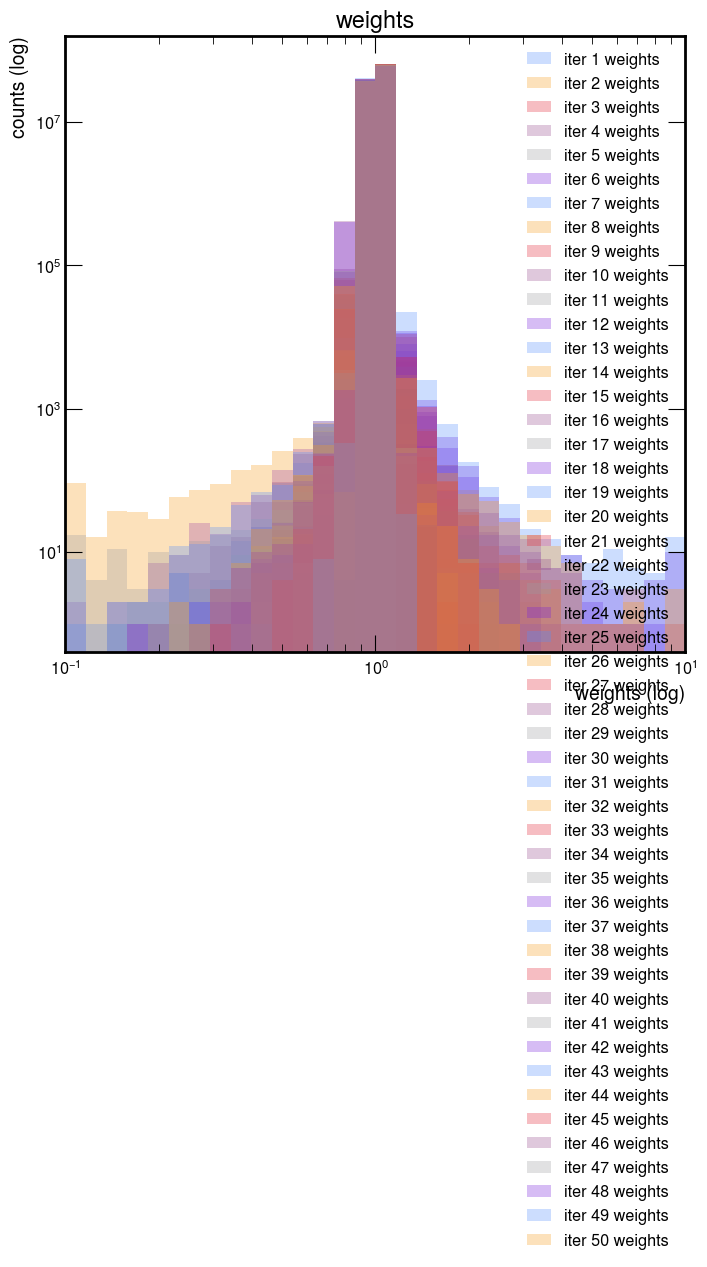

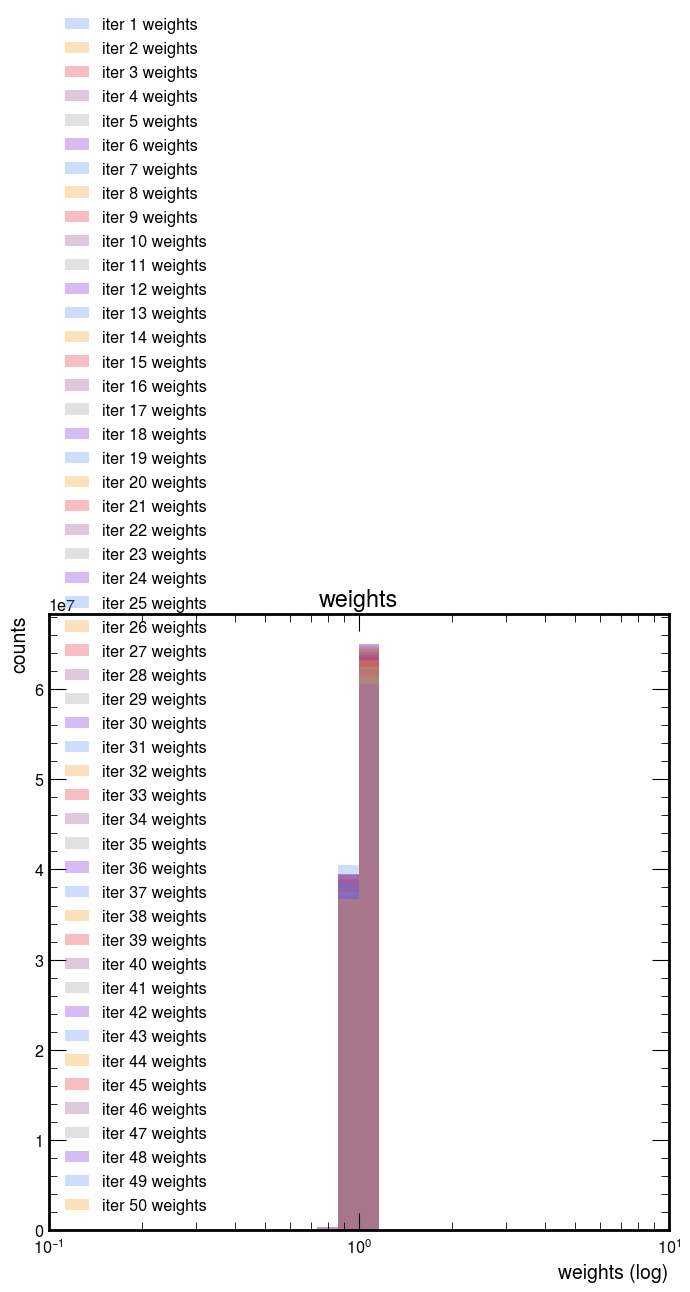

In [17]:
# plot and check dctr rwgt
font = {'size'   : 14}
rc('font', **font)

wgts_args = []
for i, _ in enumerate(wgts_list):
    wgts_args.append([wgts_list[i], rf'iter {i + 1} weights'])
    
# wgts_args.append([wgts_mean_per_event, rf'mean weights']) # mean wgt per event

# y log scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 10) # log x
# DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin') # linear x

# y lin scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 10, yscale='lin') # log x
# DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin', yscale='lin') # linear x


In [18]:
# check weights

# when building ratio of square root of squared weights, the value we are comparing against has wgt = 1 for all events 
# -> /sqrt(num_events) is all we need

def get_wgts_stats(wgts_list):
    min_wgt_list    = []
    max_wgt_list    = []
    mean_wgt_list   = []
    ratio_wgts_list = []
    sqrt_num_events = math.sqrt(len(wgts_list[0]))
    for i, wgts in enumerate(wgts_list):
        min_wgt_list.append(np.min(wgts))
        max_wgt_list.append(np.max(wgts))
        mean_wgt_list.append(np.mean(wgts))
        
        sqrt_sum_wgts_squared = math.sqrt(np.sum(np.power(wgts, 2)))
        ratio_wgts_list.append(sqrt_num_events/sqrt_sum_wgts_squared)

    return np.array(min_wgt_list), np.array(max_wgt_list), np.array(mean_wgt_list), np.array(ratio_wgts_list)


In [20]:
min_wgt_list, max_wgt_list, mean_wgt_list, ratio_wgt_list = get_wgts_stats(wgts_list)
np.set_printoptions(precision=5, suppress=True)

print(f'{min_wgt_list   = }\n')
print(f'{max_wgt_list   = }\n')
print(f'{mean_wgt_list  = }\n')
print(f'{ratio_wgt_list = }\n')

mean_mean_wgt = np.mean(mean_wgt_list)
std_mean_wgt  = np.std(mean_wgt_list)

mean_ratio_wgt = np.mean(ratio_wgt_list)
std_ratio_wgt  = np.std(ratio_wgt_list)

print(f'mean weights:\n\
{mean_mean_wgt:.5f} +/- {std_mean_wgt:.5f}\n')

print(f'ratio of sqrt of sum of squared weights:\n\
{mean_ratio_wgt:.5f} +/- {std_ratio_wgt:.5f}')


min_wgt_list   = array([0.27991, 0.75408, 0.62474, 0.15968, 0.41794, 0.29487, 0.2552 ,
       0.7722 , 0.35087, 0.8505 , 0.76026, 0.06439, 0.77288, 0.00306,
       0.5086 , 0.57653, 0.52569, 0.40904, 0.07948, 0.40783, 0.5009 ,
       0.52419, 0.14136, 0.44592, 0.51361, 0.76968, 0.4098 , 0.55923,
       0.02418, 0.3729 , 0.84358, 0.19951, 0.66721, 0.6841 , 0.86184,
       0.20974, 0.67669, 0.42485, 0.82608, 0.2515 , 0.4128 , 0.25226,
       0.00949, 0.8541 , 0.31778, 0.81493, 0.19054, 0.17809, 0.67545,
       0.23275])

max_wgt_list   = array([  1.21074,   3.22327,   1.27923,   1.59616,   1.20297,  26.49552,
         1.83727,   2.67237,   1.51945,   1.24117,   1.27037,   7.3769 ,
         1.18768,   3.62851,   1.60854,   1.36367,   1.55158,   5.07777,
         2.46832,   2.42248,   8.65614,   1.46461,   1.30125,   1.27759,
         2.09809,   1.83818,   1.9359 ,   1.34074,   1.25593,   2.4473 ,
         1.63742,   1.24004,   2.86773,   1.55578,   1.21051,   3.30178,
         1.12787,   

In [ ]:
# covariance calculations

In [21]:
# covariance matrix using weighted samples
def weighted_cov(data, weights):
    # print(f'{np.shape(data) = }')

    # Calculate weighted mean
    weighted_mean = np.average(data, axis=0, weights=weights)
    # print(f'{np.shape(weighted_mean) = }')
    # print(f'{weighted_mean = }')

    # Calculate centered data
    centered_data = data - weighted_mean
    # print(f'{np.shape(centered_data) = }')

    # Calculate weighted covariance matrix
    vars = len(data[0,:]) # num of variables per sample
    weighted_covariance = np.zeros(shape=(vars, vars))
    for i in range(vars):
        for j in range(vars):
            weighted_covariance[i, j] = np.sum(
                weights * centered_data[:,i] * centered_data[:,j]) / np.sum(weights)

    return weighted_covariance
    

# correlation matrix using weighted samples
def weighted_corr(data, weights):
    cov = weighted_cov(data, weights)

    # Calculate diagonal matrix for standard deviations
    std_dev = np.sqrt(np.diag(cov))
    std_dev_matrix = np.outer(std_dev, std_dev)

    # Calculate correlation matrix
    weighted_correlation = cov / std_dev_matrix

    return weighted_correlation
    


In [22]:
import matplotlib.patheffects as pe

def plot_matrix(matrix, title, variable_labels = None, vmin=None, vmax=None, savefig = './plots/down/matrix.pdf'):
    font = {'size'   : 14}
    rc('font', **font)

    assert len(matrix[0,:]) == len(matrix[:,0]), 'matrix is not square'
    
    if variable_labels is not None:
        assert len(variable_labels) == len(matrix[0, :]), 'length of variable_labels does not match the dimension of the square matrix'
    else:
        variable_labels = np.arange(1, len(matrix) + 1) # Labels for variables is bin number
    
    figsize = (max(8, (matrix.shape[1]+1)*0.9), max(7, matrix.shape[0])*0.9)
    plt.figure(figsize=figsize)
    
    if vmin is not None and vmax is not None:
        plt.matshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax, fignum=1, aspect='auto')  # Set colormap limits if specified
    else:
        plt.matshow(matrix, cmap='viridis', fignum=1, aspect='auto')  # Default behavior with automatic colormap limits

    plt.colorbar()  # Add colorbar to show scale
    plt.title(title)  # Set the title of the plot
    
    # Add annotations to show values in the heatmap
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', color='black',  path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    # Label x-axis with variable names
    plt.xticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.xlabel('bin number')  # Label x-axis

    # Label y-axis with variable names
    plt.yticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.ylabel('bin number')  # Label y-axis

    plt.savefig(savefig)
    plt.show()



In [23]:
# 10 bin pt(tt)
bins = np.linspace(0,1000,11)


In [24]:
hist_list = []

for i, wgt in enumerate(wgts_list):
    hist, _ = np.histogram(X1_plot[:,0], weights = wgt, bins = bins, density=True)
    hist_list.append(hist)
    print(f'calculated hist for {i + 1} iterations')

hist_list = np.array(hist_list)
np.save(f'{data_dir}/down_pt_10bin_hist_50iter.npy', hist_list)



calculated hist for 1 iterations
calculated hist for 2 iterations
calculated hist for 3 iterations
calculated hist for 4 iterations
calculated hist for 5 iterations
calculated hist for 6 iterations
calculated hist for 7 iterations
calculated hist for 8 iterations
calculated hist for 9 iterations
calculated hist for 10 iterations
calculated hist for 11 iterations
calculated hist for 12 iterations
calculated hist for 13 iterations
calculated hist for 14 iterations
calculated hist for 15 iterations
calculated hist for 16 iterations
calculated hist for 17 iterations
calculated hist for 18 iterations
calculated hist for 19 iterations
calculated hist for 20 iterations
calculated hist for 21 iterations
calculated hist for 22 iterations
calculated hist for 23 iterations
calculated hist for 24 iterations
calculated hist for 25 iterations
calculated hist for 26 iterations
calculated hist for 27 iterations
calculated hist for 28 iterations
calculated hist for 29 iterations
calculated hist for 30 

In [25]:
np.set_printoptions(precision=3, suppress=False)

hist_list = np.load(f'{data_dir}/down_pt_10bin_hist_50iter.npy')
print(hist_list[::10])
print(hist_list.shape)



[[8.375e-03 1.181e-03 2.850e-04 9.387e-05 3.620e-05 1.527e-05 7.001e-06
  3.380e-06 1.699e-06 8.843e-07]
 [8.383e-03 1.177e-03 2.838e-04 9.329e-05 3.566e-05 1.486e-05 6.754e-06
  3.237e-06 1.618e-06 8.376e-07]
 [8.388e-03 1.174e-03 2.823e-04 9.272e-05 3.569e-05 1.500e-05 6.850e-06
  3.293e-06 1.651e-06 8.566e-07]
 [8.385e-03 1.173e-03 2.838e-04 9.406e-05 3.633e-05 1.528e-05 6.982e-06
  3.358e-06 1.682e-06 8.722e-07]
 [8.380e-03 1.177e-03 2.843e-04 9.383e-05 3.625e-05 1.531e-05 7.023e-06
  3.391e-06 1.706e-06 8.871e-07]]
(50, 10)


[[ 1.    -0.857 -0.867 -0.71  -0.557 -0.498 -0.481 -0.467 -0.451 -0.437]
 [-0.857  1.     0.515  0.257  0.099  0.065  0.075  0.084  0.087  0.095]
 [-0.867  0.515  1.     0.888  0.722  0.633  0.593  0.567  0.544  0.519]
 [-0.71   0.257  0.888  1.     0.946  0.87   0.811  0.759  0.714  0.671]
 [-0.557  0.099  0.722  0.946  1.     0.974  0.929  0.879  0.831  0.785]
 [-0.498  0.065  0.633  0.87   0.974  1.     0.986  0.956  0.919  0.881]
 [-0.481  0.075  0.593  0.811  0.929  0.986  1.     0.991  0.969  0.942]
 [-0.467  0.084  0.567  0.759  0.879  0.956  0.991  1.     0.994  0.978]
 [-0.451  0.087  0.544  0.714  0.831  0.919  0.969  0.994  1.     0.995]
 [-0.437  0.095  0.519  0.671  0.785  0.881  0.942  0.978  0.995  1.   ]]


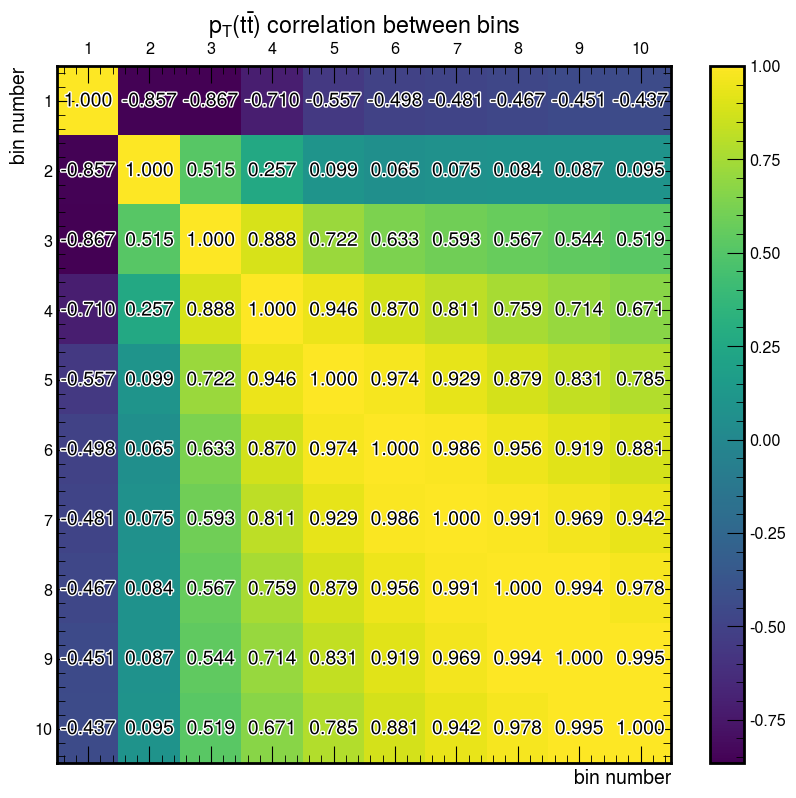

In [27]:
corr_matrix = weighted_corr(hist_list, weights = [1]*len(hist_list))

np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

plot_matrix(corr_matrix, title = r'p$_{T}$$(t\bar{t})$ correlation between bins', savefig = './plots/down/corr_matrix_pt_tt_10bins_50iter.pdf')


In [29]:
np.set_printoptions(precision=3, suppress = False)

print(hist_list.shape)
print(hist_list[::5])

mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(mean_hist)
print(std_hist)

# calc other histograms to compare to
target_hist, _  = np.histogram(X0_plot[:,0], bins=bins, density=True)
nominal_hist, _ = np.histogram(X1_plot[:,0], bins=bins, density=True)
# paper_hist, _   = np.histogram(X1_plot[:,0], weights=paper_wgts, bins=bins, density=True)

# print(paper_hist)

# add last value to hist for plotting reasonscenter_mass_energy = '(13 TeV)'
target_hist  = np.concatenate((target_hist, [target_hist[-1]]))
nominal_hist = np.concatenate((nominal_hist, [nominal_hist[-1]]))
# paper_hist   = np.concatenate((paper_hist, [paper_hist[-1]]))

mean_hist    = np.concatenate((mean_hist, [mean_hist[-1]]))
std_hist     = np.concatenate((std_hist, [std_hist[-1]]))



(50, 10)
[[8.375e-03 1.181e-03 2.850e-04 9.387e-05 3.620e-05 1.527e-05 7.001e-06
  3.380e-06 1.699e-06 8.843e-07]
 [8.383e-03 1.174e-03 2.836e-04 9.412e-05 3.658e-05 1.549e-05 7.124e-06
  3.444e-06 1.734e-06 9.037e-07]
 [8.383e-03 1.177e-03 2.838e-04 9.329e-05 3.566e-05 1.486e-05 6.754e-06
  3.237e-06 1.618e-06 8.376e-07]
 [8.389e-03 1.171e-03 2.825e-04 9.304e-05 3.589e-05 1.509e-05 6.886e-06
  3.305e-06 1.653e-06 8.550e-07]
 [8.388e-03 1.174e-03 2.823e-04 9.272e-05 3.569e-05 1.500e-05 6.850e-06
  3.293e-06 1.651e-06 8.566e-07]
 [8.382e-03 1.175e-03 2.846e-04 9.384e-05 3.613e-05 1.519e-05 6.950e-06
  3.350e-06 1.684e-06 8.776e-07]
 [8.385e-03 1.173e-03 2.838e-04 9.406e-05 3.633e-05 1.528e-05 6.982e-06
  3.358e-06 1.682e-06 8.722e-07]
 [8.371e-03 1.181e-03 2.877e-04 9.521e-05 3.678e-05 1.553e-05 7.138e-06
  3.451e-06 1.739e-06 9.071e-07]
 [8.380e-03 1.177e-03 2.843e-04 9.383e-05 3.625e-05 1.531e-05 7.023e-06
  3.391e-06 1.706e-06 8.871e-07]
 [8.382e-03 1.174e-03 2.854e-04 9.390e-05 3.61

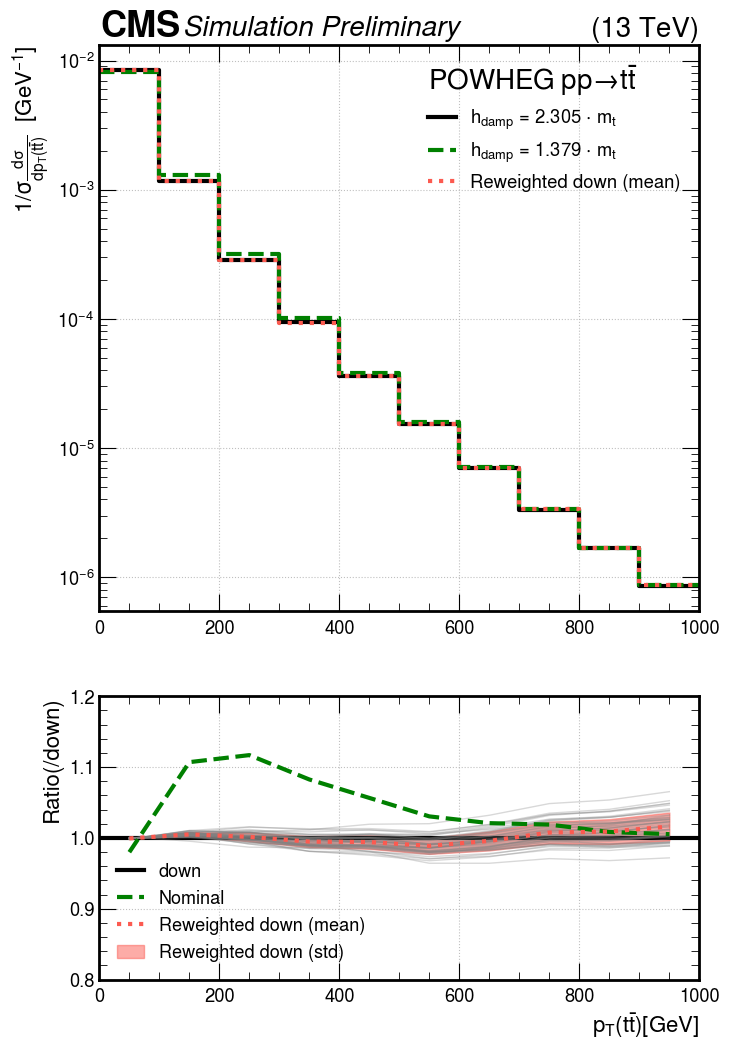

In [30]:
# plot the hists above
ratio_ylim = [0.80, 1.20]

import mplhep as hep
plt.style.use(hep.style.CMS)
plt_style_10a = {'color':'Green', 'linewidth':3, 'linestyle':'--'} #, 'density':True, 'histtype':'step'}
plt_style_11a = {'color':'black', 'linewidth':3, 'linestyle':'-'} #', 'density':True, 'histtype':'step'}
plt_style_12a = {'color':'#FC5A50', 'linewidth':3, 'linestyle':':'} #, 'density':True, 'histtype':'step'}
plt_style_13a = {'color':'blue', 'linewidth':3, 'linestyle':'-.'} #, 'density':True, 'histtype':'step'}

font = {'size'   : 16}
rc('font', **font)

# labels and titles
pythia_text = r'$POWHEG \; pp \to  t\bar{t}$'
hep_text = 'Simulation Preliminary'
def make_legend(ax, title):
    leg = ax.legend(frameon=False)
    leg.set_title(title, prop={'size':20})
    leg._legend_box.align = "left"
    plt.tight_layout()


# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8,11), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=1)

# First subplot
bin_centers = (bins[:-1] + bins[1:]) / 2.0

axes[0].step(bins, target_hist, label = r'h$_{damp}$ = 2.305 $\cdot$ m$_t$', where='post', **plt_style_11a)
axes[0].step(bins, nominal_hist, label = r'h$_{damp}$ = 1.379 $\cdot$ m$_t$', where='post', **plt_style_10a)
axes[0].step(bins, mean_hist, label = 'Reweighted down (mean)', where='post', **plt_style_12a)

# axes[0].step(bins, paper_hist, label = 'rwgt valentina', where='post', **plt_style_13a)


# Calculate the ratios of histograms
ratio_0 = target_hist / target_hist
ratio_1 = mean_hist / target_hist
ratio_std = std_hist / mean_hist
ratio_2 = nominal_hist / target_hist
# ratio_3 = paper_hist / target_hist


make_legend(axes[0], pythia_text)
obs = r'p_{T}'
part = r't\bar{t}'
unit =r' [GeV]'
inv_unit = r' [GeV$^{-1}$]'
start = bins[0]
stop = bins[-1]

# Constructing the label using Python string formatting
label = r'$1$/$\sigma \frac{d\sigma}{d %s(%s)}$ %s' % (obs, part, inv_unit)

axes[0].set_ylabel(label)
axes[0].set_yscale('log')
axes[0].grid(True)

# Second subplot

axes[1].plot([start, stop], [1,1], '-', color='black',  linewidth=3, label='down')
for hist in hist_list:
    axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=1, alpha = 0.3, color = 'grey')
axes[1].plot(bin_centers, ratio_2[:-1], label='Nominal', **plt_style_10a)
axes[1].plot(bin_centers, ratio_1[:-1], label = 'Reweighted down (mean)', **plt_style_12a)
axes[1].fill_between(bin_centers, (ratio_1*(1+ratio_std))[:-1], (ratio_1*(1-ratio_std))[:-1], color='#FC5A50', alpha = 0.5, label = 'Reweighted down (std)') 

# axes[1].plot(bin_centers, ratio_3[:-1], label='rwgt valentina', **plt_style_13a)

axes[1].set_xlabel(fr'${obs}({part}){unit}$')
axes[1].set_ylabel(f'Ratio(/down)')
axes[1].grid(True)

# print(f'uncertainty NLO: {uncert_nrm_list[0]}')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[1].set_ylim(ratio_ylim)

axes[0].set_xlim([start,stop])
axes[1].set_xlim([start,stop])
axes[1].legend(fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text(hep_text, loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, '(13 TeV)', ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

plt.savefig('./plots/down/40M_50iter_pt_tt_10bin.pdf')


In [31]:
# 11 bin eta(tt)
bins = np.linspace(-5,5,12)


In [32]:
hist_list = []

for i, wgt in enumerate(wgts_list):
    hist, _ = np.histogram(X1_plot[:,2], weights = wgt, bins = bins, density=True)
    hist, _ = np.histogram(X1_plot[:,2], weights = wgt, bins = bins, density=True)
    hist_list.append(hist)
    print(f'calculated hist for {i + 1} iterations')

hist_list = np.array(hist_list)
np.save(f'{data_dir}/down_eta_11bin_hist_50iter.npy', hist_list)


calculated hist for 1 iterations
calculated hist for 2 iterations
calculated hist for 3 iterations
calculated hist for 4 iterations
calculated hist for 5 iterations
calculated hist for 6 iterations
calculated hist for 7 iterations
calculated hist for 8 iterations
calculated hist for 9 iterations
calculated hist for 10 iterations
calculated hist for 11 iterations
calculated hist for 12 iterations
calculated hist for 13 iterations
calculated hist for 14 iterations
calculated hist for 15 iterations
calculated hist for 16 iterations
calculated hist for 17 iterations
calculated hist for 18 iterations
calculated hist for 19 iterations
calculated hist for 20 iterations
calculated hist for 21 iterations
calculated hist for 22 iterations
calculated hist for 23 iterations
calculated hist for 24 iterations
calculated hist for 25 iterations
calculated hist for 26 iterations
calculated hist for 27 iterations
calculated hist for 28 iterations
calculated hist for 29 iterations
calculated hist for 30 

In [33]:
np.set_printoptions(precision=5, suppress=False)

hist_list = np.load(f'{data_dir}/down_eta_11bin_hist_50iter.npy')
print(hist_list[::10])
print(hist_list.shape)


[[0.08727 0.13456 0.13891 0.10239 0.06283 0.04743 0.06283 0.10252 0.1391
  0.13477 0.08738]
 [0.0874  0.13476 0.13903 0.10235 0.06274 0.04733 0.06273 0.10243 0.13906
  0.13476 0.0874 ]
 [0.08763 0.13495 0.13896 0.10218 0.06262 0.04725 0.06259 0.10218 0.13891
  0.13504 0.08769]
 [0.08748 0.13475 0.13887 0.10226 0.06273 0.04735 0.06273 0.10239 0.13908
  0.13487 0.08748]
 [0.08745 0.13477 0.13894 0.10229 0.06276 0.04738 0.06276 0.1024  0.139
  0.13478 0.08746]]
(50, 11)


In [34]:
mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(hist_list.shape)
print(mean_hist)
print(std_hist)


(50, 11)
[0.08755 0.13484 0.13891 0.10222 0.06269 0.04732 0.06268 0.1023  0.13898
 0.13492 0.08761]
[1.55551e-04 1.52436e-04 1.10897e-04 1.03739e-04 9.72002e-05 8.46342e-05
 9.92369e-05 1.18772e-04 1.14128e-04 1.37967e-04 1.57797e-04]


[[ 1.     0.789 -0.228 -0.823 -0.662 -0.597 -0.701 -0.897 -0.64   0.48
   0.84 ]
 [ 0.789  1.     0.352 -0.699 -0.846 -0.831 -0.88  -0.893 -0.428  0.452
   0.574]
 [-0.228  0.352  1.     0.327 -0.198 -0.299 -0.215  0.007  0.079 -0.297
  -0.418]
 [-0.823 -0.699  0.327  1.     0.839  0.759  0.833  0.859  0.187 -0.871
  -0.868]
 [-0.662 -0.846 -0.198  0.839  1.     0.99   0.992  0.823  0.027 -0.79
  -0.661]
 [-0.597 -0.831 -0.299  0.759  0.99   1.     0.983  0.77  -0.016 -0.735
  -0.587]
 [-0.701 -0.88  -0.215  0.833  0.992  0.983  1.     0.866  0.107 -0.764
  -0.684]
 [-0.897 -0.893  0.007  0.859  0.823  0.77   0.866  1.     0.536 -0.654
  -0.857]
 [-0.64  -0.428  0.079  0.187  0.027 -0.016  0.107  0.536  1.     0.175
  -0.488]
 [ 0.48   0.452 -0.297 -0.871 -0.79  -0.735 -0.764 -0.654  0.175  1.
   0.724]
 [ 0.84   0.574 -0.418 -0.868 -0.661 -0.587 -0.684 -0.857 -0.488  0.724
   1.   ]]


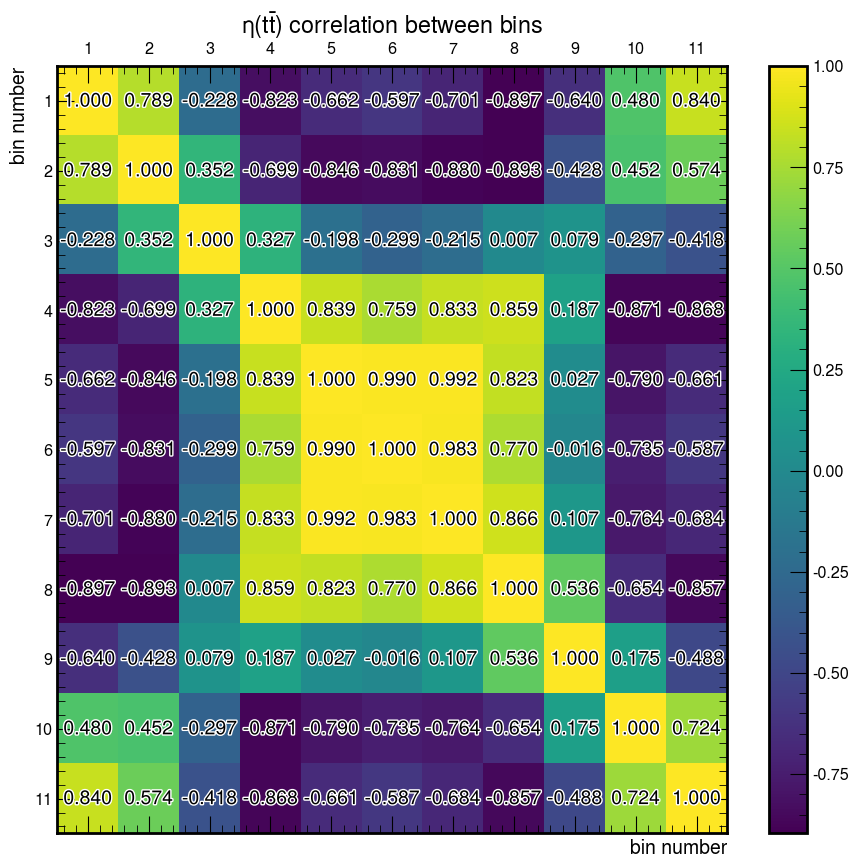

In [35]:
corr_matrix = weighted_corr(hist_list, weights = [1]*len(hist_list))

np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

plot_matrix(corr_matrix, title = r'$\eta(t\bar{t})$ correlation between bins', savefig = './plots/down/corr_matrix_eta_tt_11bins.pdf')


In [36]:
np.set_printoptions(precision=3, suppress = False)
print(hist_list.shape)
print(hist_list[::5])

mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(mean_hist)
print(std_hist)

# calc other histograms to compare to
target_hist, _  = np.histogram(X0_plot[:,2], bins=bins, density=True)
nominal_hist, _ = np.histogram(X1_plot[:,2], bins=bins, density=True)
# paper_hist, _   = np.histogram(X1_plot[:,2], weights=paper_wgts, bins=bins, density=True)

# add last value to hist for plotting reasonscenter_mass_energy = '(13 TeV)'
target_hist  = np.concatenate((target_hist, [target_hist[-1]]))
nominal_hist = np.concatenate((nominal_hist, [nominal_hist[-1]]))
# paper_hist   = np.concatenate((paper_hist, [paper_hist[-1]]))

mean_hist    = np.concatenate((mean_hist, [mean_hist[-1]]))
std_hist     = np.concatenate((std_hist, [std_hist[-1]]))



(50, 11)
[[0.087 0.135 0.139 0.102 0.063 0.047 0.063 0.103 0.139 0.135 0.087]
 [0.088 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.088]
 [0.087 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.087]
 [0.088 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.088]
 [0.088 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.088]
 [0.088 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.088]
 [0.087 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.087]
 [0.087 0.134 0.139 0.102 0.063 0.048 0.063 0.103 0.139 0.135 0.087]
 [0.087 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.087]
 [0.088 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.088]]
[0.088 0.135 0.139 0.102 0.063 0.047 0.063 0.102 0.139 0.135 0.088]
[1.556e-04 1.524e-04 1.109e-04 1.037e-04 9.720e-05 8.463e-05 9.924e-05
 1.188e-04 1.141e-04 1.380e-04 1.578e-04]


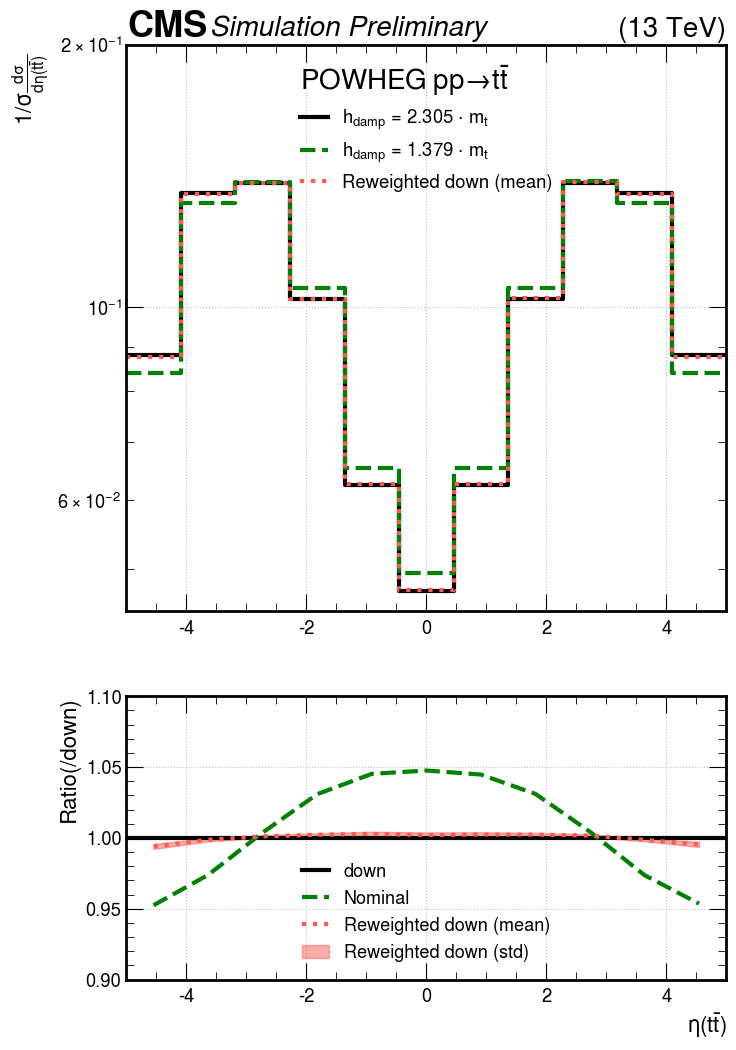

In [37]:
# plot the hists above
ratio_ylim = [0.90, 1.10]

import mplhep as hep
plt.style.use(hep.style.CMS)
plt_style_10a = {'color':'Green', 'linewidth':3, 'linestyle':'--'} #, 'density':True, 'histtype':'step'}
plt_style_11a = {'color':'black', 'linewidth':3, 'linestyle':'-'} #', 'density':True, 'histtype':'step'}
plt_style_12a = {'color':'#FC5A50', 'linewidth':3, 'linestyle':':'} #, 'density':True, 'histtype':'step'}
plt_style_13a = {'color':'blue', 'linewidth':3, 'linestyle':'-.'} #, 'density':True, 'histtype':'step'}

font = {'size'   : 16}
rc('font', **font)

# labels and titles
pythia_text = r'$POWHEG \; pp \to  t\bar{t}$'
hep_text = 'Simulation Preliminary'
def make_legend(ax, title):
    leg = ax.legend(frameon=False)
    leg.set_title(title, prop={'size':20})
    leg._legend_box.align = "left"
    plt.tight_layout()


# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8,11), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=1)

# First subplot
bin_centers = (bins[:-1] + bins[1:]) / 2.0

axes[0].step(bins, target_hist, label = r'h$_{damp}$ = 2.305 $\cdot$ m$_t$', where='post', **plt_style_11a)
axes[0].step(bins, nominal_hist, label = r'h$_{damp}$ = 1.379 $\cdot$ m$_t$', where='post', **plt_style_10a)
axes[0].step(bins, mean_hist, label = 'Reweighted down (mean)', where='post', **plt_style_12a)

# axes[0].step(bins, paper_hist, label = 'rwgt valentina', where='post', **plt_style_13a)


# Calculate the ratios of histograms
ratio_0 = target_hist / target_hist
ratio_1 = mean_hist / target_hist
ratio_std = std_hist / mean_hist
ratio_2 = nominal_hist / target_hist
# ratio_3 = paper_hist / target_hist


make_legend(axes[0], pythia_text)
obs = r'\eta'
part = r't\bar{t}'
unit =r' '
inv_unit = r' '
start = bins[0]
stop = bins[-1]

# Constructing the label using Python string formatting
label = r'$1$/$\sigma \frac{d\sigma}{d %s(%s)}$ %s' % (obs, part, inv_unit)

axes[0].set_ylabel(label)
axes[0].set_yscale('log')
axes[0].set_ylim((None, 0.2))
axes[0].grid(True)

# Second subplot

axes[1].plot([start, stop], [1,1], '-', color='black',  linewidth=3, label='down')
# for hist in hist_list:
#     axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=1, alpha = 0.1, color = 'grey')

axes[1].plot(bin_centers, ratio_2[:-1], label='Nominal', **plt_style_10a)
axes[1].plot(bin_centers, ratio_1[:-1], label = 'Reweighted down (mean)', **plt_style_12a)
axes[1].fill_between(bin_centers, (ratio_1*(1+ratio_std))[:-1], (ratio_1*(1-ratio_std))[:-1], color='#FC5A50', alpha = 0.5, label = 'Reweighted down (std)') 

# axes[1].plot(bin_centers, ratio_3[:-1], label='rwgt valentina', **plt_style_13a)

axes[1].set_xlabel(fr'${obs}({part}){unit}$')
axes[1].set_ylabel(f'Ratio(/down)')
axes[1].grid(True)

# print(f'uncertainty NLO: {uncert_nrm_list[0]}')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[1].set_ylim(ratio_ylim)

axes[0].set_xlim([start,stop])
axes[1].set_xlim([start,stop])
axes[1].legend(fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text(hep_text, loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, '(13 TeV)', ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

plt.savefig('./plots/down/40M_50iter_eta_tt_11bin.pdf')


In [38]:
# 18 bin pt(tt)
bins = np.linspace(0,1000,19)


In [39]:

hist_list = []

for i, wgt in enumerate(wgts_list):
    hist, _ = np.histogram(X1_plot[:,0], weights = wgt, bins = bins, density=True)
    hist_list.append(hist)
    print(f'calculated hist for {i + 1} iterations')

hist_list = np.array(hist_list)
np.save(f'{data_dir}/down_pt_18bin_hist_50iter.npy', hist_list)


calculated hist for 1 iterations
calculated hist for 2 iterations
calculated hist for 3 iterations
calculated hist for 4 iterations
calculated hist for 5 iterations
calculated hist for 6 iterations
calculated hist for 7 iterations
calculated hist for 8 iterations
calculated hist for 9 iterations
calculated hist for 10 iterations
calculated hist for 11 iterations
calculated hist for 12 iterations
calculated hist for 13 iterations
calculated hist for 14 iterations
calculated hist for 15 iterations
calculated hist for 16 iterations
calculated hist for 17 iterations
calculated hist for 18 iterations
calculated hist for 19 iterations
calculated hist for 20 iterations
calculated hist for 21 iterations
calculated hist for 22 iterations
calculated hist for 23 iterations
calculated hist for 24 iterations
calculated hist for 25 iterations
calculated hist for 26 iterations
calculated hist for 27 iterations
calculated hist for 28 iterations
calculated hist for 29 iterations
calculated hist for 30 

In [40]:
hist_list = np.load(f'{data_dir}/down_pt_18bin_hist_50iter.npy')

print(hist_list.shape)
print(hist_list[::5])



(50, 18)
[[1.176e-02 3.768e-03 1.296e-03 5.539e-04 2.715e-04 1.444e-04 8.122e-05
  4.773e-05 2.904e-05 1.797e-05 1.144e-05 7.450e-06 4.946e-06 3.350e-06
  2.268e-06 1.535e-06 1.102e-06 7.534e-07]
 [1.178e-02 3.754e-03 1.288e-03 5.508e-04 2.701e-04 1.443e-04 8.156e-05
  4.815e-05 2.939e-05 1.824e-05 1.162e-05 7.579e-06 5.037e-06 3.414e-06
  2.313e-06 1.567e-06 1.126e-06 7.693e-07]
 [1.177e-02 3.769e-03 1.290e-03 5.527e-04 2.703e-04 1.437e-04 8.067e-05
  4.718e-05 2.850e-05 1.753e-05 1.109e-05 7.190e-06 4.754e-06 3.207e-06
  2.164e-06 1.460e-06 1.045e-06 7.122e-07]
 [1.179e-02 3.753e-03 1.285e-03 5.497e-04 2.691e-04 1.431e-04 8.051e-05
  4.734e-05 2.878e-05 1.779e-05 1.129e-05 7.331e-06 4.850e-06 3.275e-06
  2.210e-06 1.491e-06 1.066e-06 7.276e-07]
 [1.178e-02 3.765e-03 1.287e-03 5.496e-04 2.688e-04 1.428e-04 8.020e-05
  4.709e-05 2.860e-05 1.768e-05 1.122e-05 7.291e-06 4.829e-06 3.263e-06
  2.205e-06 1.490e-06 1.068e-06 7.294e-07]
 [1.178e-02 3.754e-03 1.289e-03 5.521e-04 2.712e-04 1.44

[[ 1.    -0.704 -0.892 -0.541 -0.415 -0.334 -0.253 -0.19  -0.159 -0.153
  -0.159 -0.17  -0.176 -0.182 -0.184 -0.188 -0.198 -0.2  ]
 [-0.704  1.     0.526 -0.184 -0.326 -0.373 -0.389 -0.389 -0.375 -0.353
  -0.327 -0.304 -0.283 -0.266 -0.255 -0.235 -0.212 -0.198]
 [-0.892  0.526  1.     0.604  0.407  0.263  0.138  0.055  0.019  0.014
   0.023  0.036  0.042  0.05   0.054  0.057  0.065  0.068]
 [-0.541 -0.184  0.604  1.     0.938  0.829  0.697  0.583  0.505  0.46
   0.434  0.421  0.408  0.4    0.395  0.382  0.373  0.364]
 [-0.415 -0.326  0.407  0.938  1.     0.959  0.866  0.771  0.7    0.655
   0.626  0.609  0.591  0.578  0.568  0.552  0.538  0.526]
 [-0.334 -0.373  0.263  0.829  0.959  1.     0.97   0.911  0.852  0.806
   0.771  0.744  0.717  0.694  0.675  0.652  0.631  0.613]
 [-0.253 -0.389  0.138  0.697  0.866  0.97   1.     0.982  0.944  0.904
   0.868  0.836  0.805  0.775  0.75   0.723  0.698  0.674]
 [-0.19  -0.389  0.055  0.583  0.771  0.911  0.982  1.     0.988  0.962
   0.933  0.

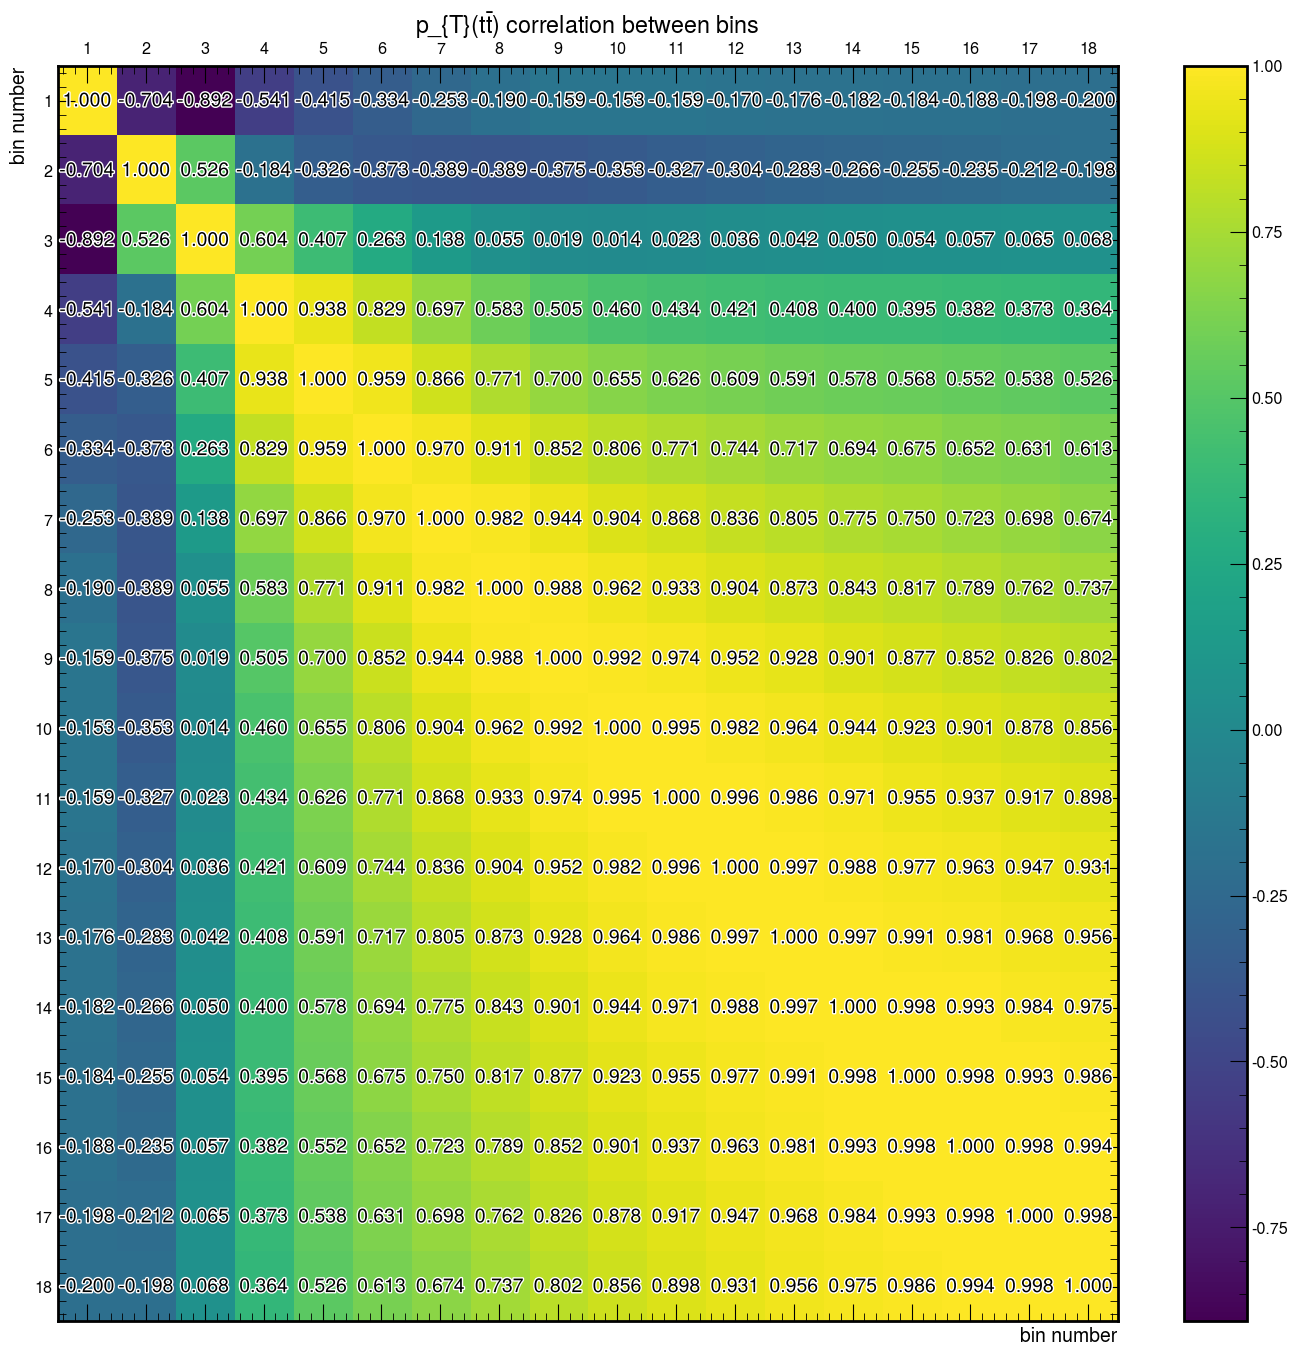

In [41]:
corr_matrix = weighted_corr(hist_list, weights = [1]*len(hist_list))

np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

plot_matrix(corr_matrix, title = r'p_{T}$(t\bar{t})$ correlation between bins', savefig = './plots/down/corr_matrix_pt_tt_18bins.pdf')



In [42]:
np.set_printoptions(precision=3, suppress = False)
print(hist_list.shape)
print(hist_list[::5])

mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(mean_hist)
print(std_hist)

# calc other histograms to compare to
target_hist, _  = np.histogram(X0_plot[:,0], bins=bins, density=True)
nominal_hist, _ = np.histogram(X1_plot[:,0], bins=bins, density=True)
# paper_hist, _   = np.histogram(X1_plot[:,0], weights=paper_wgts, bins=bins, density=True)

# add last value to hist for plotting reasonscenter_mass_energy = '(13 TeV)'
target_hist  = np.concatenate((target_hist, [target_hist[-1]]))
nominal_hist = np.concatenate((nominal_hist, [nominal_hist[-1]]))
# paper_hist   = np.concatenate((paper_hist, [paper_hist[-1]]))

mean_hist    = np.concatenate((mean_hist, [mean_hist[-1]]))
std_hist     = np.concatenate((std_hist, [std_hist[-1]]))



(50, 18)
[[1.176e-02 3.768e-03 1.296e-03 5.539e-04 2.715e-04 1.444e-04 8.122e-05
  4.773e-05 2.904e-05 1.797e-05 1.144e-05 7.450e-06 4.946e-06 3.350e-06
  2.268e-06 1.535e-06 1.102e-06 7.534e-07]
 [1.178e-02 3.754e-03 1.288e-03 5.508e-04 2.701e-04 1.443e-04 8.156e-05
  4.815e-05 2.939e-05 1.824e-05 1.162e-05 7.579e-06 5.037e-06 3.414e-06
  2.313e-06 1.567e-06 1.126e-06 7.693e-07]
 [1.177e-02 3.769e-03 1.290e-03 5.527e-04 2.703e-04 1.437e-04 8.067e-05
  4.718e-05 2.850e-05 1.753e-05 1.109e-05 7.190e-06 4.754e-06 3.207e-06
  2.164e-06 1.460e-06 1.045e-06 7.122e-07]
 [1.179e-02 3.753e-03 1.285e-03 5.497e-04 2.691e-04 1.431e-04 8.051e-05
  4.734e-05 2.878e-05 1.779e-05 1.129e-05 7.331e-06 4.850e-06 3.275e-06
  2.210e-06 1.491e-06 1.066e-06 7.276e-07]
 [1.178e-02 3.765e-03 1.287e-03 5.496e-04 2.688e-04 1.428e-04 8.020e-05
  4.709e-05 2.860e-05 1.768e-05 1.122e-05 7.291e-06 4.829e-06 3.263e-06
  2.205e-06 1.490e-06 1.068e-06 7.294e-07]
 [1.178e-02 3.754e-03 1.289e-03 5.521e-04 2.712e-04 1.44

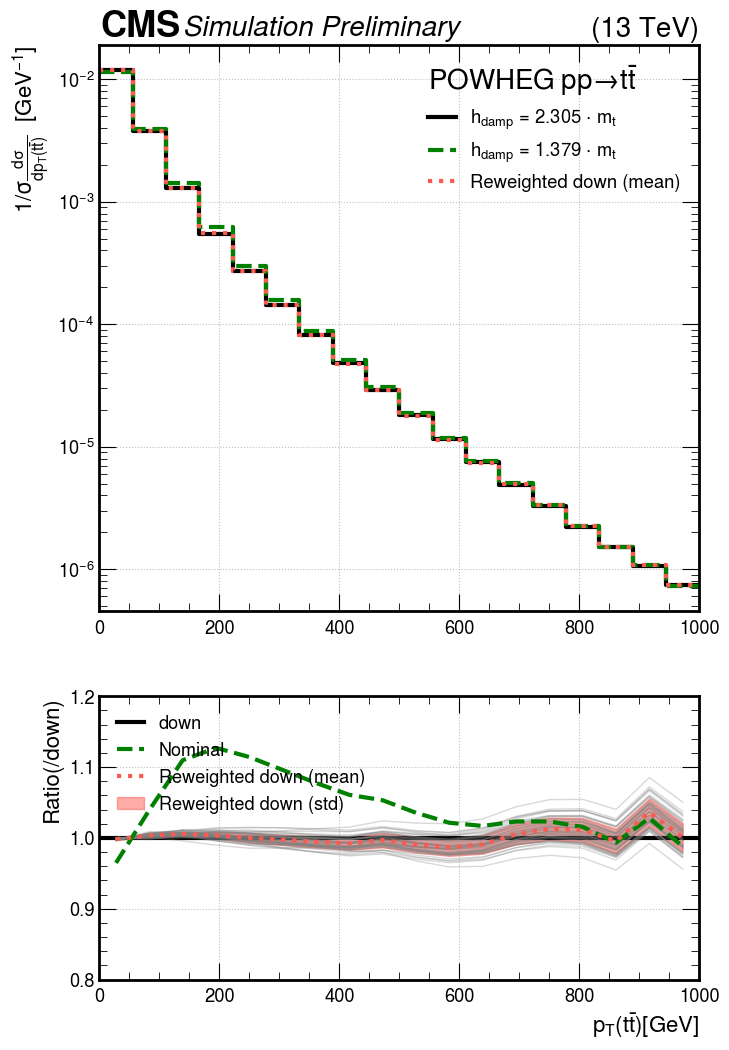

In [43]:
# plot the hists above
ratio_ylim = [0.80, 1.20]

import mplhep as hep
plt.style.use(hep.style.CMS)
plt_style_10a = {'color':'Green', 'linewidth':3, 'linestyle':'--'} #, 'density':True, 'histtype':'step'}
plt_style_11a = {'color':'black', 'linewidth':3, 'linestyle':'-'} #', 'density':True, 'histtype':'step'}
plt_style_12a = {'color':'#FC5A50', 'linewidth':3, 'linestyle':':'} #, 'density':True, 'histtype':'step'}
plt_style_13a = {'color':'blue', 'linewidth':3, 'linestyle':'-.'} #, 'density':True, 'histtype':'step'}

font = {'size'   : 16}
rc('font', **font)

# labels and titles
pythia_text = r'$POWHEG \; pp \to  t\bar{t}$'
hep_text = 'Simulation Preliminary'
def make_legend(ax, title):
    leg = ax.legend(frameon=False)
    leg.set_title(title, prop={'size':20})
    leg._legend_box.align = "left"
    plt.tight_layout()


# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8,11), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=1)

# First subplot
bin_centers = (bins[:-1] + bins[1:]) / 2.0

axes[0].step(bins, target_hist, label = r'h$_{damp}$ = 2.305 $\cdot$ m$_t$', where='post', **plt_style_11a)
axes[0].step(bins, nominal_hist, label = r'h$_{damp}$ = 1.379 $\cdot$ m$_t$', where='post', **plt_style_10a)
axes[0].step(bins, mean_hist, label = 'Reweighted down (mean)', where='post', **plt_style_12a)

# axes[0].step(bins, paper_hist, label = 'rwgt valentina', where='post', **plt_style_13a)


# Calculate the ratios of histograms
ratio_0 = target_hist / target_hist
ratio_1 = mean_hist / target_hist
ratio_std = std_hist / mean_hist
ratio_2 = nominal_hist / target_hist
# ratio_3 = paper_hist / target_hist


make_legend(axes[0], pythia_text)
obs = r'p_{T}'
part = r't\bar{t}'
unit =r' [GeV]'
inv_unit = r' [GeV$^{-1}$]'
start = bins[0]
stop = bins[-1]

# Constructing the label using Python string formatting
label = r'$1$/$\sigma \frac{d\sigma}{d %s(%s)}$ %s' % (obs, part, inv_unit)

axes[0].set_ylabel(label)
axes[0].set_yscale('log')
axes[0].grid(True)

# Second subplot

axes[1].plot([start, stop], [1,1], '-', color='black',  linewidth=3, label='down')
for hist in hist_list:
    axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=1, alpha = 0.3, color = 'grey')
axes[1].plot(bin_centers, ratio_2[:-1], label='Nominal', **plt_style_10a)
axes[1].plot(bin_centers, ratio_1[:-1], label = 'Reweighted down (mean)', **plt_style_12a)
axes[1].fill_between(bin_centers, (ratio_1*(1+ratio_std))[:-1], (ratio_1*(1-ratio_std))[:-1], color='#FC5A50', alpha = 0.5, label = 'Reweighted down (std)') 

# axes[1].plot(bin_centers, ratio_3[:-1], label='rwgt valentina', **plt_style_13a)

axes[1].set_xlabel(fr'${obs}({part}){unit}$')
axes[1].set_ylabel(f'Ratio(/down)')
axes[1].grid(True)

# print(f'uncertainty NLO: {uncert_nrm_list[0]}')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[1].set_ylim(ratio_ylim)

axes[0].set_xlim([start,stop])
axes[1].set_xlim([start,stop])
axes[1].legend(fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text(hep_text, loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, '(13 TeV)', ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

plt.savefig('./plots/down/40M_50iter_pt_tt_18bin.pdf')


In [ ]:
# plotting/hist stats

In [ ]:
# tt-pair pt
chi2_all = []
mae_all  = []

for i, wgts in enumerate(wgts_list):
    # setdown args for plotting
    args = [(X0_plot[:,0], X0_plot_wgt, '     down hdamp = 1.379 '),
            (X1_plot[:,0], X1_plot_wgt, 'nominal hdamp = 2.305'),
            (X1_plot[:,0], wgts,      fr'nom$\rightarrow$down rwgt iter {i + 1}')]
    
    log_bins = np.logspace(np.log10(1), np.log10(1000), 31)
    DCTR.plot_ratio_cms(args, bins = log_bins, y_scale='log', ratio_ylim=[0.9, 1.1], save_prefix = f'iter_{i+1:02d}',
                        part_label=r't\bar{t}', arg_label=r'p_{T}', unit=r' [GeV]', inv_unit=r' [GeV$^{-1}$]')
    # stats
    mae_list, chi2_list, p_list = DCTR.plot_ratio(args, bins = log_bins, stats_only = True, verbose=False)
    
    # last element is the one we're interested in, the others are the baseline nom and down
    print(f'\n iteration {i + 1}: chi2, mae, \n {chi2_list[-1]}, {mae_list[-1]} \n')

    chi2_all.append(chi2_list[-1])
    mae_all.append(mae_list[-1])



In [ ]:
chi2_all = np.array(chi2_all)
mae_all = np.array(mae_all)

print(f'{chi2_all = }\n')

print(f'{mae_all = }\n')

min_chi2  = np.min(chi2_all)
max_chi2  = np.max(chi2_all)
mean_chi2 = np.mean(chi2_all)
std_chi2  = np.std(chi2_all)

min_mae   = np.min(mae_all)
max_mae   = np.max(mae_all)
mean_mae  = np.mean(mae_all)
std_mae   = np.std(mae_all)

print(f'chi2: min, max, mean, std\n\
{min_chi2:5f}, {max_chi2:5f}, {mean_chi2:5f}, {std_chi2:5f}\n')

print(f'mea : min, max, mean, std\n\
{min_mae:5f}, {max_mae:5f}, {mean_mae:5f}, {std_mae:5f}\n')

# pt(tt) log_bins = np.logspace(np.log10(1), np.log10(1000), 31)

In [ ]:
# tt-pair eta
chi2_all = []
mae_all  = []

for i, wgts in enumerate(wgts_list):
    # setdown args for plotting
    args = [(X0_plot[:,2], X0_plot_wgt, '     down hdamp = 1.379 '),
            (X1_plot[:,2], X1_plot_wgt, 'nominal hdamp = 2.305'),
            (X1_plot[:,2], wgts,      fr'nom$\rightarrow$down rwgt iter {i + 1}')]
    
    bins = np.linspace(-5, 5, 31)
    DCTR.plot_ratio_cms(args, bins = bins, y_scale='log', ratio_ylim=[0.9, 1.1], save_prefix = f'iter_{i+1:02d}',
                        part_label=r't\bar{t}', arg_label=r'\eta', unit=r' ', inv_unit=r' ')
    # stats
    mae_list, chi2_list, p_list = DCTR.plot_ratio(args, bins = log_bins, stats_only = True, verbose=False)
    
    # last element is the one we're interested in, the others are the baseline nom and down
    print(f'\n iteration {i + 1}: chi2, mae, \n {chi2_list[-1]}, {mae_list[-1]} \n')

    chi2_all.append(chi2_list[-1])
    mae_all.append(mae_list[-1])


In [ ]:
# eta(tt) bins = np.linspace(-5, 5, 31)

chi2_all = np.array(chi2_all)
mae_all = np.array(mae_all)

print(f'{chi2_all = }\n')
print(f'{mae_all = }\n')

min_chi2  = np.min(chi2_all)
max_chi2  = np.max(chi2_all)
mean_chi2 = np.mean(chi2_all)
std_chi2  = np.std(chi2_all)

min_mae   = np.min(mae_all)
max_mae   = np.max(mae_all)
mean_mae  = np.mean(mae_all)
std_mae   = np.std(mae_all)

print(f'chi2: min, max, mean, std\n\
{min_chi2:5f}, {max_chi2:5f}, {mean_chi2:5f}, {std_chi2:5f}\n')

print(f'mae : min, max, mean, std\n\
{min_mae:5f}, {max_mae:5f}, {mean_mae:5f}, {std_mae:5f}\n')

